# STAT 647 homework 1 - Diya Li

This notebook contains two questions listed below 

## Q1

Load the US Covid-19 county-level cumulative cases from

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

Draw a map showing the county-level Covid-19 case rates (# of cumulative cases/population) on Aug-25 for Texas.

List the top 10 counties in TX with the highest case rates.

For the Q1, I used US census data to get the population of each county. I uploaded it to: https://drive.google.com/file/d/1_8mr396i5Y4cpDMk0Sv6Ynt8fnCuK_EI/view?usp=sharing

In [1]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
# Download the time series csv
# Upload the CS_GasSTATION.csv to this notebook

--2020-08-31 01:55:24--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2439563 (2.3M) [text/plain]
Saving to: ‘time_series_covid19_confirmed_US.csv’

time_series_covid19 100%[===================>]   2.33M  --.-KB/s    in 0.1s    

2020-08-31 01:55:24 (18.1 MB/s) - ‘time_series_covid19_confirmed_US.csv’ saved [2439563/2439563]



In [2]:
!pip install geopandas

     |████████████████████████████████| 972kB 5.9MB/s 
     |████████████████████████████████| 10.9MB 15.4MB/s 
     |████████████████████████████████| 14.7MB 308kB/s 


In [3]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import json
import geopandas 

# load basemap from plotly datsets
counties = geopandas.read_file("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json")
# make sure the type of each dataset is the same
counties['id'] = counties['id'].astype(int)

# read census data 
# I uploaded the census to https://drive.google.com/file/d/1_8mr396i5Y4cpDMk0Sv6Ynt8fnCuK_EI/view?usp=sharing
df_census = pd.read_csv("/content/census.csv", dtype={'CountyId': int})

In [4]:
# check the base map datatype
counties.dtypes
counties.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,1001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.49677 32.34444, -86.71790 32.402..."
1,1009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.57780 33.76532, -86.75914 33.840..."
2,1017,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413 32.87053, -85.12342 32.772..."
3,1021,0500000US01021,01,021,Chilton,County,692.854,"POLYGON ((-86.51734 33.02057, -86.51596 32.929..."
4,1033,0500000US01033,01,033,Colbert,County,592.619,"POLYGON ((-88.13999 34.58170, -88.13925 34.587..."


In [5]:
# check census dataset datatype
df_census.dtypes
df_census.head()

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,155376,52562,1348,29364,735,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,20269,33368,2551,17561,798,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,17662,43404,3431,20911,1889,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,42513,47412,2630,22021,850,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9


In [6]:
# Load timeseries dataset
df_timeseries_covid = pd.read_csv("/content/time_series_covid19_confirmed_US.csv")
df_timeseries_covid.head(3)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,845,863,877,891,900,909,932,941,949,963,972,988,1010,1024,1030,1030,1050,1065,1086,1169,1174,1162,1188,1196,1196,1206,1218,1219,1235,1241,1240,1255,1264,1266,1286,1286,1281,1284,1296,1309
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2077,2164,2423,2473,2620,2665,2727,2793,2865,2984,3056,3095,3175,3210,3263,3322,3380,3443,3502,3544,3651,3670,3710,3744,3791,3839,3877,3888,3906,3931,3957,3997,4037,4069,4083,4100,4166,4199,4230,4307
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,484,487,501,507,516,523,529,535,538,539,550,554,562,563,563,564,565,569,573,575,576,579,581,586,590,598,604,605,606,613,619,622,626,629,633,628,616,614,620,624


In [7]:
df_timeseries_covid = df_timeseries_covid.dropna(axis=0)

In [8]:
# caculate Covid-19 case rates
def get_case_rates(countyId, cases):
    try:
        # get population from census data
        population = df_census[df_census['CountyId'] == int(countyId)]['TotalPop'].values[0]
        if population == 0:
            # if the county census is not exits, return 
            # print("return Null")
            return np.NaN
    except:
        # print("return Null")
        return np.NaN
    return round(cases/population, 4)

# select the confirm case on 8/25/20
df_timeseries_covid['case_rate'] = df_timeseries_covid.apply(lambda x: get_case_rates(x['FIPS'], x['8/25/20']), axis=1)

In [9]:
# prepare the basemap and dataset to get the maps
df_timeseries_covid['fips'] = df_timeseries_covid['FIPS'].astype(int)

In [10]:
df_plot = df_timeseries_covid.loc[:, ['fips', 'case_rate']]

In [11]:
counties.to_file("counties.geojson", driver='GeoJSON')
with open("counties.geojson") as j:
    counties = json.load(j)

In [12]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
for f_index in range(len(counties['features'])):
    counties['features'][f_index]['id'] = int(counties['features'][f_index]['id'])

A map showing the county-level Covid-19 case rates (# of cumulative cases/population) on Aug-25 for Texas.
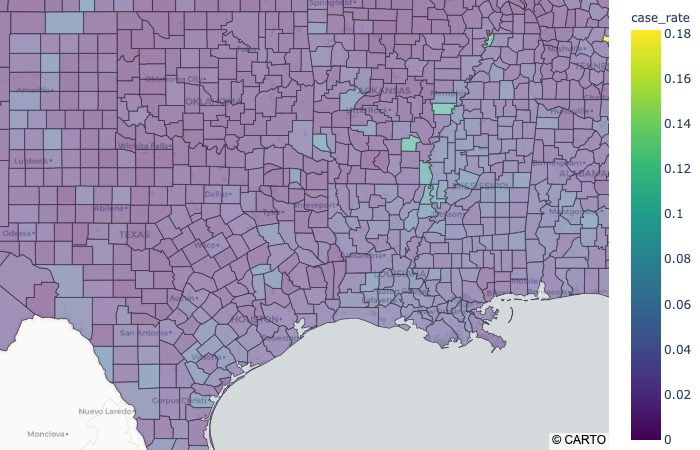


In [13]:
import plotly.express as px

# draw maps
fig1 = px.choropleth_mapbox(df_plot, geojson=counties, locations='fips', color='case_rate',
                           color_continuous_scale="Viridis",
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'Covid-19 case rates':'# of cumulative cases/population'}
                          )
fig1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig1.show()

Output hidden; open in https://colab.research.google.com to view.

Top 10 counties in TX with the highest case rates:

In [14]:
df_tx_top_10 = df_timeseries_covid[df_timeseries_covid['Province_State'] =='Texas'].nlargest(10, 'case_rate')
df_tx_top_10

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,case_rate,fips
2851,84048313,US,USA,840,48313.0,Madison,Texas,US,30.966947,-95.930038,"Madison, Texas, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,229,234,240,241,609,631,633,637,645,645,645,645,645,645,650,658,666,666,668,667,676,685,686,684,684,684,684,685,685,688,690,689,690,779,836,834,833,830,0.0557,48313
2856,84048323,US,USA,840,48323.0,Maverick,Texas,US,28.742919,-100.315769,"Maverick, Texas, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1440,1440,1440,1440,1622,1730,1802,1852,1989,1989,1989,1989,2210,1852,2210,2321,2321,2321,2321,2321,2321,2569,2596,2596,2596,2596,2596,2596,2596,2596,3117,3117,3117,3168,3228,3248,3258,3258,0.0551,48323
2875,84048355,US,USA,840,48355.0,Nueces,Texas,US,27.736286,-97.543329,"Nueces, Texas, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9961,10136,10351,10351,10647,10901,11160,11390,12301,12301,12478,12575,12813,13321,13552,13918,14073,15244,15423,15731,16234,16403,16527,16878,17044,17124,17322,17494,17600,17854,17854,18069,18181,18349,18444,18536,18664,18664,0.0512,48355
2868,84048341,US,USA,840,48341.0,Moore,Texas,US,35.837692,-101.893028,"Moore, Texas, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,967,968,978,978,978,986,1000,1008,1008,1013,1013,1013,1023,1035,1044,1047,1050,1050,1050,1063,1064,1077,1080,1082,1082,1082,1092,1096,1100,1101,1103,1103,1103,1109,1112,1112,1117,1118,0.0504,48341
2836,84048283,US,USA,840,48283.0,La Salle,Texas,US,28.344531,-99.099088,"La Salle, Texas, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,347,351,351,351,351,348,350,357,357,357,357,357,357,356,357,362,362,362,361,362,362,362,361,364,364,364,364,367,368,368,367,367,367,365,366,366,366,365,0.0492,48283
2825,84048255,US,USA,840,48255.0,Karnes,Texas,US,28.907053,-97.859601,"Karnes, Texas, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,181,203,206,206,206,239,239,266,266,298,298,300,344,391,556,562,632,632,639,644,646,648,661,672,672,672,691,693,694,696,720,720,720,730,732,734,736,740,0.0485,48255
2728,84048061,US,USA,840,48061.0,Cameron,Texas,US,26.145242,-97.481404,"Cameron, Texas, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6854,7162,7846,7827,7827,8201,8777,9424,10155,10971,10971,13516,14781,15564,15865,15865,16290,16290,16590,16906,17069,17316,17618,17816,17816,18005,18170,18338,18559,18874,19001,19225,19225,19862,20335,20739,20739,20853,0.0473,48061
2935,84048471,US,USA,840,48471.0,Walker,Texas,US,30.738730,-95.574410,"Walker, Texas, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2661,2685,2697,2714,2738,2749,2757,2772,2792,2814,2814,2840,2842,2838,2861,2874,2902,3005,3051,3074,3095,3128,3184,3190,3189,3190,3197,3202,3223,3247,3278,3320,3340,3344,3426,3443,3443,3627,0.0472,48471
2710,84048025,US,USA,840,48025.0,Bee,Texas,US,28.417617,-97.742156,"Bee, Texas, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,285,369,369,400,399,417,461,482,498,511,511,626,669,696,704,885,1073,1089,1207,1246,1277,1303,1344,1374,1382,1387,1412,1429,1438,1450,1456,1469,1473,1489,1490,1496,1516,1591,0.0455,48025
2792,84048189,US,USA,840,48189.0,Hale,Texas,US,34.070449,-101.826811,"Hale, Texas, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1032,1049,1061,1085,1085,1103,1162,1162,1173,1185,1185,1185,1230,1244,1257,1257,1285,1285,1285,1

list out the top 10 county name: 

they are: 'Madison', 'Maverick', 'Nueces', 'Moore', 'La Salle', 'Karnes',
       'Cameron', 'Walker', 'Bee', 'Hale'

In [15]:
df_tx_top_10['Admin2'].values

array(['Madison', 'Maverick', 'Nueces', 'Moore', 'La Salle', 'Karnes',
       'Cameron', 'Walker', 'Bee', 'Hale'], dtype=object)

## Q2

CS_GasStations.csv is a data frame that contains the locations of 45 gas stations in College Station and the visit counts to these gas stations during the week of Aug-10.  

Draw a spatial map showing the visit counts of the 45 gas stations. 

List the top 3 gas stations with the highest visit counts.

In [16]:
# first, upload the CS_GasStations.csv and load the data
df_gas = pd.read_csv("/content/CS_GasStations.csv")
df_gas.head()

,Unnamed: 0,latitude,longitude,name,address,raw_visit_counts
0,1,30.611260,-96.303868,Express Stop,450 Southwest Pkwy E,76
1,2,30.612299,-96.341210,Huerta's Taqueria,150 Lamar Street At Memorial Student Ctr Texas...,5
2,3,30.617512,-96.346936,Chevron,301 University Dr,79
3,4,30.584538,-96.286347,Exxon Express Mart,3998 State Highway 6 S,331
4,5,30.568410,-96.296350,DD's Express Mart,600 Graham Rd,43


In [17]:
fig2 = px.scatter_mapbox(df_gas, lat='latitude', lon='longitude', hover_name="name", hover_data=["address", "raw_visit_counts"],
                        color_discrete_sequence=["fuchsia"], zoom=10, height=500, center = {"lat": 30.611260, "lon": -96.303868})
fig2.update_layout(mapbox_style="open-street-map")
fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2.show()

Then the top three visit counts gas station is: 'Exxon Mobil', 'Exxon Express Mart', 'Shell Oil'

In [18]:
df_gas_visittop3 = df_gas.nlargest(3, 'raw_visit_counts')
df_gas_visittop3

,Unnamed: 0,latitude,longitude,name,address,raw_visit_counts
12,13,30.571165,-96.310088,Exxon Mobil,12727 FM 2154 Rd,551
3,4,30.584538,-96.286347,Exxon Express Mart,3998 State Highway 6 S,331
15,16,30.571956,-96.310779,Shell Oil,12677 FM 2154 Rd,319


In [19]:
df_gas_visittop3['name'].values

array(['Exxon Mobil', 'Exxon Express Mart', 'Shell Oil'], dtype=object)